<font size="5">Build Your Own ANUGA Model (BYOAM) </font>

<font size="3">In this notebook, we will:

- determine the model domain boundaries

- assign a total upstream discharge (m3/s)

    
- download time series of downstream water level




</font>

<font size="3">Before you can run this notebook, you should have run the 2_SetupDEM notebook</font>


<font size=5> Step #1: Mount Google Drive and Grant Access <font> <br>




<font size=3> When you run the next cell, a pop-up window will appear asking you to grant access to your Google Drive. You must approve or the notebook will not work. <font> <br>


In [1]:
import sys
import os
path = os.getcwd() + '/'
where_to_mount = '/content/drive/'

from google.colab import drive
drive.mount(where_to_mount, force_remount=True)

mounted_drive = where_to_mount + 'MyDrive/'

Mounted at /content/drive/


<font size=5> Step #2: Install packages. <font> <br>
<font size=3> This cell should install all Python packages you need for each tutorial.<font>

In [2]:
import os
os.chdir(mounted_drive)
if os.path.isdir(mounted_drive + 'komo_estuary_tutorial'):
  print('## Updating the local git repository \n')
  os.chdir(mounted_drive + '/komo_estuary_tutorial')
  ! git pull 
else:
  print('## Pulling the git repository with files for the tutorial\n')
  ! git clone https://github.com/achri19/komo_estuary_tutorial.git

print('\n## Installing the Python packages needed for these tutorials\n')
!/bin/bash $mounted_drive/komo_estuary_tutorial/install_packages.sh

!unzip -f komo_starter.zip -d $mounted_drive 


## Updating the local git repository 

Already up to date.

## Installing the Python packages needed for these tutorials

(1) Install pip packages to /content/drive/MyDrive/installations
nose mpi4py triangle Pmw pymetis cmocean geopandas fiona pygeos rasterio rasterstats scikit-fmm rtree pyTMD Orinoco
(2) Install gdal
(3) Install netcdf4
(4) Download anuga_core github repository
https://github.com/GeoscienceAustralia/anuga_core
(5) Install anuga
(7) Completed
Archive:  komo_starter.zip


<font size=5> Step #3: Set up working directories<font> 


<font size=3> We will access data files stored on a shared Google Drive. You will also need to save files to your own Google Drive.<font>



In [3]:
path = where_to_mount + 'MyDrive/processing/'
path_code = path + 'code/'
path_templates = path +  'templates/'
path_configs = path + 'configs/'
path_ancillary = path + 'ancillary/'
sys.path.insert(1,path_code)


<font size=5> Step #4: Now we will import Python packages, which will be used for future tutorials. If there are any errors, try rerunning the first cell <font> 




In [4]:
import sys
import os
import pandas as pd
import shutil
from datetime import datetime
from string import Template
import fnmatch
import geopandas as gpd
import rasterio
from osgeo import gdal 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import rtree
import pygeos
import pyTMD


In [5]:
sys.path.insert(1,path_code)

from BYOM_Utilities_V1 import (build_directory,
                               get_extent_parameters,
                               setup_AOI_files, 
                               make_polygons,
                               make_channel_networks,
                               make_model_foundation, get_inlet,
                               set_boundary_conditions, get_tidal_boundary,get_tide_data_pytmd,
                               make_watermask,
                               more_opening)

<font size='5' color = 'red' > Set Boundaries <br> Set the AOI again and make sure the working directory is set. If you ran 2_Setup_DEM notebook then the directory should already be made. </font>


In [6]:
AOI = 'komo'

Path((mounted_drive + AOI)).mkdir(parents=True, exist_ok=True)

skip = False
res = 30 #meters
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))

working_path,folders = build_directory(mounted_drive, AOI)

elev_name = 'Elevation_ocean-GEBCO_land-GLO30_above1260m-wdpower_below1260m-plane_wetland-uni0m_lakes-uni1m_30'
elevationpath = folders[4] + 'elev_name'





Study area is komo
Resolution of this setup is 30m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/content/drive/MyDrive/komo/
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 
##################### 8 Setup_F

In [7]:
parameters = pd.read_csv('%s/%s_Configuration.csv' %(folders[2],AOI))
EPSG = int(parameters['EPSG'])

<font size='5' color = 'red' > Set Boundaries STEP #8a: <br> Get the downstream boundary conditions for the model </font>


In [8]:
tide_bnd_EPSG =[]
tideLAT_EPSG = 31223.17
tideLON_EPSG = 502794.61 
tideLAT_4326 = 0.2825
tideLON_4326 = 9.0253


Due to file size and copyright, we cannot share the model files for the TPXO Global Tide model. We have provided the time series needed to run a simulation, but if you'd like to produce tide data yourself, you should look here for more information: [https://www.tpxo.net/global](https://)

<font size='5' color = 'red' > Set Boundaries STEP #8b: <br> Get the upstream boundary conditions for the model </font>


In [9]:
tide_data = np.genfromtxt("%s/Tide_LAT%s_LON%s/%s_tides_20100101.csv" %(folders[5],tideLAT_4326,tideLON_4326,AOI),delimiter=',')


In [10]:
inletLAT_EPSG = 19092
inletLON_EPSG = 608911
inletLAT_4326 = 0.1727
inletLON_4326 = 9.9789 

<font size='5' color = 'red' > Make some plots! </font>


In [11]:
from rasterio.mask import mask
AOI_extent = gpd.read_file('%s%s_extent_%s.shp' %(folders[7],AOI,EPSG))
watermask = rasterio.open('%s%s_watermask_%s.tif' %(folders[8],AOI,res))
masked, mask_transform = mask(dataset=watermask,shapes=AOI_extent.geometry,crop=False)
masked = np.where(masked==-9999,np.nan,masked)

origin_x = watermask.profile['transform'][2]
origin_y = watermask.profile['transform'][5]


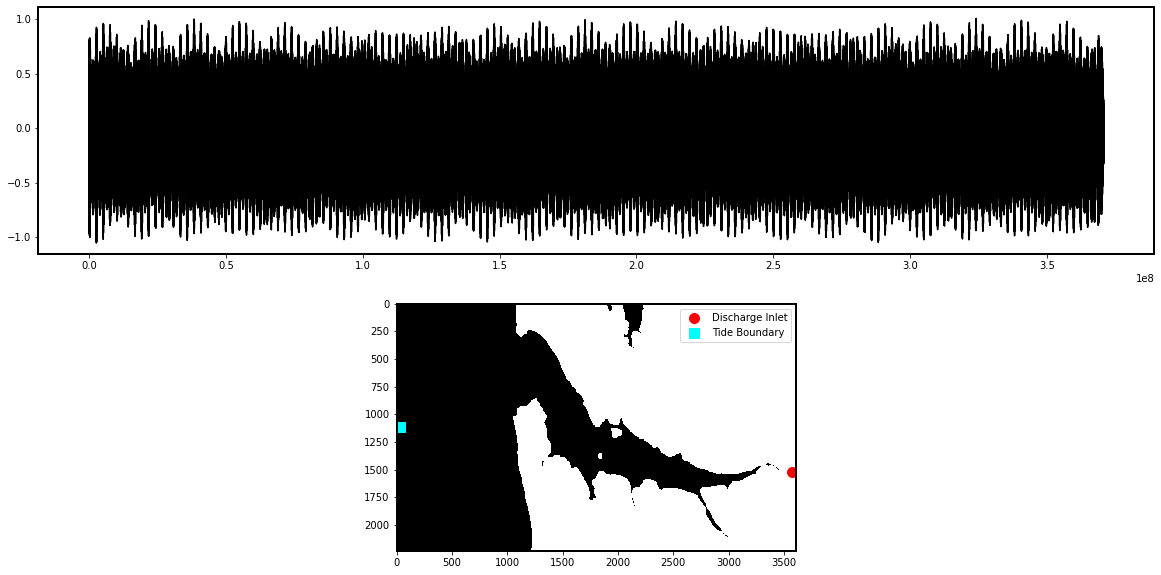

In [12]:
fig,[ax2,ax3] = plt.subplots(nrows=2,figsize=(20,10))

ax2.plot(tide_data[:,0],tide_data[:,1],'black')

ax3.imshow(masked[0],'gray')
ax3.scatter((inletLON_EPSG-origin_x)/res,(origin_y - inletLAT_EPSG)/res, s=100, c='red', marker='o',label='Discharge Inlet')
ax3.scatter((tideLON_EPSG-origin_x)/res,(origin_y - tideLAT_EPSG)/res, s=100, c='cyan', marker='s',label='Tide Boundary')
ax3.legend()

plt.savefig('%s/%s_model_boundaries_TideLAT%s_TideLON%s_InletLAT%s_InletLON%s.png' %(folders[5],AOI,tideLAT_4326,tideLON_4326,inletLAT_4326,inletLON_4326),bbox_inches='tight')

This should produce a file that can also be run on gattaca.


<font size=5 color='red'> Done getting boundary files. Move on to the next notebook 4_Build_ANUGA_Mesh.ipynb </font>
